In [50]:
import theano
from theano import tensor as T


a = T.scalar()
b = T.scalar()

y = a**b
power = theano.function(inputs = [a, b], outputs = y)

print power(1, 2)
print power(3, 4)



1.0
81.0


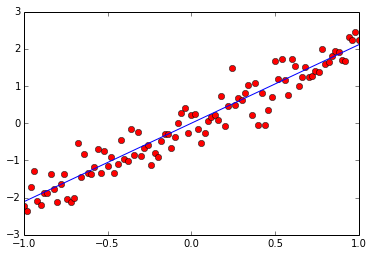

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

trX = np.linspace(-1, 1, 101)
trY = 2*trX - np.random.randn(*trX.shape)*0.33

X = T.scalar()
Y = T.scalar()

def model(X, w):
    return X * w

w = theano.shared(np.asarray(0., dtype = theano.config.floatX))
y = model(X, w)

cost = T.mean(T.sqr(y - Y))
grad = T.grad(cost = cost, wrt = w)
updates = [[w, w - grad * 0.01]]

train = theano.function(inputs = [X, Y], outputs = cost, updates = updates, allow_input_downcast = True)
for i in range(100):
    for x, y in zip(trX, trY):
        train(x, y)
        
plt.plot(trX, trY, 'ro')
plt.plot([i for i in range(-1, 2)], [w.get_value()*i for i in range(-1, 2)])
plt.show()
        

In [40]:
import os

dataDir = '/media/datasets/mnist'

def oneHot(x, n):
    if type(x) == list:
        x = np.array(x)
    x = x.flatten()
    res = np.zeros((len(x), n))
    res[np.arange(len(x)), x] = 1
    return res
    
def load(nTrain = 60000, nTest = 10000):
    
    #read file
    rawFile = open(os.path.join(dataDir, 'train-images-idx3-ubyte'))
    toMatrix = np.fromfile(file = rawFile, dtype = np.uint8)
    trainX = toMatrix[16:].reshape((60000, 28*28)).astype(float)
    rawFile = open(os.path.join(dataDir, 'train-labels-idx1-ubyte'))
    toMatrix = np.fromfile(file = rawFile, dtype = np.uint8)
    trainY = toMatrix[8:].reshape((60000))
    rawFile = open(os.path.join(dataDir, 't10k-images-idx3-ubyte'))
    toMatrix = np.fromfile(file = rawFile, dtype = np.uint8)
    testX = toMatrix[16:].reshape((10000, 28*28)).astype(float)
    rawFile = open(os.path.join(dataDir, 't10k-labels-idx1-ubyte'))
    toMatrix = np.fromfile(file = rawFile, dtype = np.uint8)
    testY = toMatrix[8:].reshape((10000))
    
    #scaling
    trainX = trainX/255.
    testX = testX/255.
    
    trainX = trainX[:nTrain]
    trainY = trainY[:nTrain]
    testX = testX[:nTest]
    testY = testY[:nTest]
    
    trainY = oneHot(trainY, 10)
    testY = oneHot(testY, 10)
    
    return trainX, trainY, testX, testY



In [52]:
def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def initWeight(shape):
    return theano.shared(floatX(np.random.randn(*shape)*0.01))

def model(X, w):
    #linear combination of inputs => softmax output
    return T.nnet.softmax(T.dot(X, w))

trainX, trainY, testX, testY = load()

X = T.fmatrix()
Y = T.fmatrix()

w = initWeight((28*28, 10))
output = model(X, w)
predict = T.argmax(output, axis = 1)

#gradient descent
cost = T.mean(T.nnet.categorical_crossentropy(output, Y))
grad = T.grad(cost = cost, wrt = w)
update = [[w, w-grad*0.05]]

#define training function
train = theano.function(inputs = [X, Y], outputs = cost, updates = update, allow_input_downcast = True)
pred = theano.function(inputs = [X], outputs = predict, allow_input_downcast = True)

#batch gradient descent
for i in range(100):
    for start, end in zip(range(0, len(trainX), 128), range(128, len(trainX), 128)):
        cost = train(trainX[start:end], trainY[start:end])
        
    print i, np.mean(np.argmax(trainY, axis = 1) == pred(trainX))
    

<type 'numpy.float64'>


In [57]:
#stochastic gradient descent
def sgd(cost, params, rate = 0.05):
    grads = T.grad(cost = cost, wrt = params) 
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g*rate])
    
    return updates

def model(X, wz, wo):
    #linear combination of inputs => first layer sigmoid output
    z = T.nnet.sigmoid(T.dot(X, wz))
    #first layer sigmoid output => second layer sofmax output
    return T.nnet.softmax(T.dot(z, wo))

X = T.fmatrix()
Y = T.fmatrix()

wz = initWeight((28*28, 25*25))
wo = initWeight((25*25, 10))

output = model(X, wz, wo)
predict = T.argmax(output, axis = 1)

cost = T.mean(T.nnet.categorical_crossentropy(output, Y))
update = sgd(cost, [wz, wo])


train = theano.function(inputs = [X, Y], outputs = cost, updates = update, allow_input_downcast = True)
pred = theano.function(inputs = [X], outputs = predict, allow_input_downcast = True)

#batch sgd
for i in range(100):
    for start, end in zip(range(0, len(trainX), 128), range(128, len(trainX), 128)):
        cost = train(trainX[start:end], trainY[start:end])
        
    print i, np.mean(np.argmax(trainY, axis = 1) == pred(trainX))





0 0.694466666667
1 0.82535
2 0.861433333333
3 0.877466666667
4 0.88595
5 0.891933333333
6 0.896583333333
7 0.899633333333
8 0.901833333333
9 0.9039
10 0.906266666667
11 0.908033333333
12 0.909566666667
13 0.910816666667
14 0.911933333333
15 0.912933333333
16 0.91355
17 0.914516666667
18 0.915633333333
19 0.916466666667
20 0.917316666667
21 0.917966666667
22 0.9186
23 0.91925
24 0.919916666667
25 0.920683333333
26 0.921216666667
27 0.921916666667
28 0.92245
29 0.923033333333
30 0.923783333333
31 0.924433333333
32 0.92515
33 0.9259
34 0.92675
35 0.92745
36 0.928166666667
37 0.928816666667
38 0.929433333333
39 0.930233333333
40 0.931116666667
41 0.931716666667
42 0.932233333333
43 0.932916666667
44 0.933616666667
45 0.934266666667
46 0.935
47 0.935633333333
48 0.936283333333
49 0.936866666667
50 0.937466666667
51 0.9381
52 0.93865
53 0.939216666667
54 0.9398
55 0.940466666667
56 0.941233333333
57 0.94195
58 0.942683333333
59 0.94345
60 0.9441
61 0.944666666667
62 0.945216666667
63 0.94571